# In-class Example: The Pendulum

In the last homework, you integrated a finite-amplitude pendulum and looked at the energy conservation properties.  Now we'll look at the FFT of the pendulum.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Here's a simple class that creates a pendulum and can integrate it using _fixed timesteps_.  It is important that our data be regularly spaced for the FFT.

In [12]:
class Pendulum:
    """ a simple pendulum (w/o the small angle approximation).
    Here, theta0 is in degrees"""

    def __init__(self, theta0, g=9.81, L=9.81):

        self.theta0 = np.radians(theta0)
        self.g = g
        self.L = L

        self.t = None
        self.theta = None
        self.omega = None

    def period(self):
        """ return the period up to the theta**2 term """
        return 2.0*np.pi*np.sqrt(self.L/self.g)*(1.0 + self.theta0**2/16.0)

    def rhs(self, theta, omega):
        """ equations of motion for a pendulum
              dtheta/dt = omega
              domega/dt = - (g/L) sin theta """

        return np.array([omega, -(self.g/self.L)*np.sin(theta)])

    def integrate(self, dt, tmax):
        """integrate the equations of motion using 4th-order
        Runge-Kutta. Here, theta0 is the initial angle from vertical,
        in radians.

        Note: we use uniform steps here -- this is important to allow
        for an FFT (which needs uniformly spaced samples).

        """

        # initial conditions
        t = 0.0
        theta = self.theta0
        omega = 0.0    # at the maximum angle, the angular velocity is 0

        # store the history for plotting
        t_s = [t]
        theta_s = [theta]
        omega_s = [omega]

        while t < tmax:

            # get the RHS at time-level n
            thetadot1, omegadot1 = self.rhs(theta, omega)

            thetadot2, omegadot2 = self.rhs(theta + 0.5*dt*thetadot1,
                                            omega + 0.5*dt*omegadot1)

            thetadot3, omegadot3 = self.rhs(theta + 0.5*dt*thetadot2,
                                            omega + 0.5*dt*omegadot2)

            thetadot4, omegadot4 = self.rhs(theta + dt*thetadot3,
                                            omega + dt*omegadot3)

            theta += (dt/6.0)*(thetadot1 + 2.0*thetadot2 +
                               2.0*thetadot3 + thetadot4)

            omega += (dt/6.0)*(omegadot1 + 2.0*omegadot2 +
                               2.0*omegadot3 + omegadot4)

            t += dt

            # store
            t_s.append(t)
            theta_s.append(theta)
            omega_s.append(omega)

        self.t = np.asarray(t_s)
        self.theta = np.asarray(theta_s)
        self.omega = np.asarray(omega_s)

Let's make a model.  We'll use the expansion of the period with $\theta$ to estimate the period and try to integrate for an even number of periods.

In [15]:
p = Pendulum(10)
period = p.period()
p.integrate(0.05, 10*period)

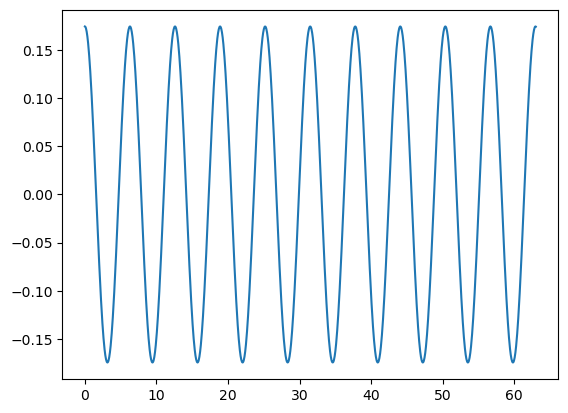

In [16]:
fig, ax = plt.subplots()
ax.plot(p.t, p.theta)

Now let's compute the FFT of this and see if we can identify the frequency.

What happens to our FFT if we don't integrate for exactly a multiple of the period?  Then our time-series is not periodic.  How does this manifest itself in the FFT?